In [247]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [249]:
df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9444,2023-09-01,331.309998,331.989990,326.779999,328.660004,328.660004,14931200
9445,2023-09-05,329.000000,334.850006,328.660004,333.549988,333.549988,18553900
9446,2023-09-06,333.380005,334.459991,330.179993,332.880005,332.880005,17535800
9447,2023-09-07,331.290009,333.079987,329.029999,329.910004,329.910004,18381000


C:\Users\ruway\AppData\Local\Temp\ipykernel_8572\2143653361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


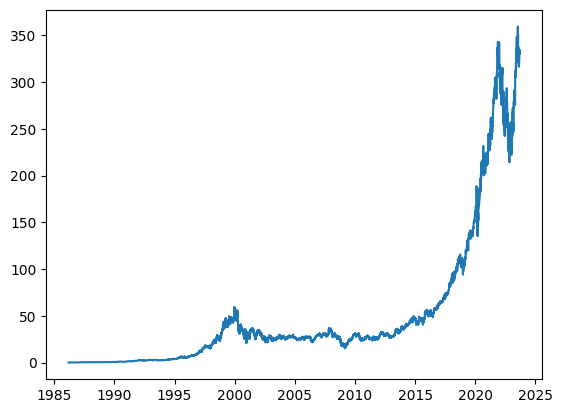

In [250]:
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])

In [251]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)

shifted_df_as_np = shifted_df.to_numpy()

In [252]:
import torch
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))

split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([8969, 7, 1]),
 torch.Size([473, 7, 1]),
 torch.Size([8969, 1]),
 torch.Size([473, 1]))

In [253]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [254]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Assuming you have already loaded and preprocessed your data (X_train, y_train, X_val, y_val) as PyTorch tensors

# Define the PyTorch model
class StockPredModel(nn.Module):
    def __init__(self, name, input_size, hidden_size, num_layers):
        super(StockPredModel, self).__init__()
        self.name = name if name else None
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        batch_size = x.size(0)  
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        lstm_out, _ = self.lstm(x, (h0, c0))
        x = self.fc1(lstm_out[:, -1, :])  # Take the last LSTM output
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def train(data_loader):
    torch.manual_seed(42)

    start = time.time()

    model = StockPredModel('StockPrediction', 1, 64, 1)

    # Define loss function (MSE loss) and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        for data in data_loader:
            inputs, _labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, _labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item()}")

        print('Saving Model')
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'loss': loss}, f'checkpoints/{model.name}_epoch_{epoch + 1}.pt')
        print('Model Saved')

    print('Finished Training')
    end = time.time()
    print('training time ', end-start)

In [260]:
def test(data_loader, *args, **kwargs):
    torch.manual_seed(42)

    model = StockPredModel('StockPrediction', 1 , 64, 1)

    # Define loss function (MSE loss) and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    checkpoint = torch.load(f'checkpoints/{model.name}_epoch_10.pt')


    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()

    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data
            outputs = model(inputs)
            test_predictions = outputs.numpy().flatten()
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

            dummies = np.zeros((inputs.shape[0], lookback+1))
            dummies[:, 0] = test_predictions
            dummies = scaler.inverse_transform(dummies)

            test_predictions = dc(dummies[:, 0])

            dummies = np.zeros((inputs.shape[0], lookback+1))
            dummies[:, 0] = targets.flatten()
            dummies = scaler.inverse_transform(dummies)

            new_y_test = dc(dummies[:, 0])

            plt.plot(new_y_test, label='Actual Close')
            plt.plot(test_predictions, label='Predicted Close')
            plt.xlabel('Day')
            plt.ylabel('Close')
            plt.ylim(200, 400)
            plt.legend()
            plt.show()

    # Calculate the mean squared error
    mse = total_loss / num_samples

    print(f"Mean Squared Error (MSE): {mse}")


In [256]:
train(train_loader)

Epoch [1/10] Loss: 0.00032630437635816634
Saving Model
Model Saved
Epoch [2/10] Loss: 4.4234864617465064e-05
Saving Model
Model Saved
Epoch [3/10] Loss: 0.0001164713830803521
Saving Model
Model Saved
Epoch [4/10] Loss: 0.00014275455032475293
Saving Model
Model Saved
Epoch [5/10] Loss: 4.6678385842824355e-05
Saving Model
Model Saved
Epoch [6/10] Loss: 6.087743895477615e-05
Saving Model
Model Saved
Epoch [7/10] Loss: 2.0944364223396406e-05
Saving Model
Model Saved
Epoch [8/10] Loss: 1.7681848476058803e-05
Saving Model
Model Saved
Epoch [9/10] Loss: 9.564727406541351e-06
Saving Model
Model Saved
Epoch [10/10] Loss: 0.00011563698353711516
Saving Model
Model Saved
Finished Training
training time  12.073900699615479


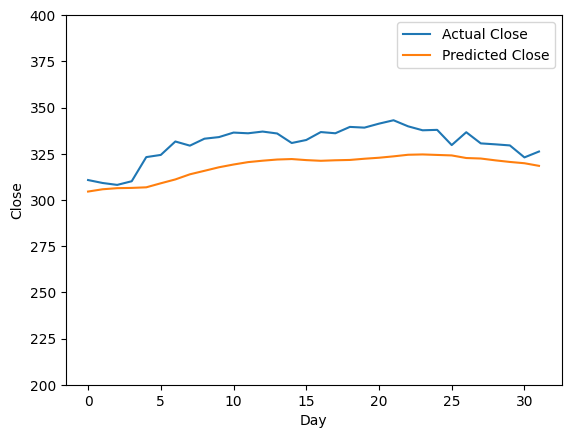

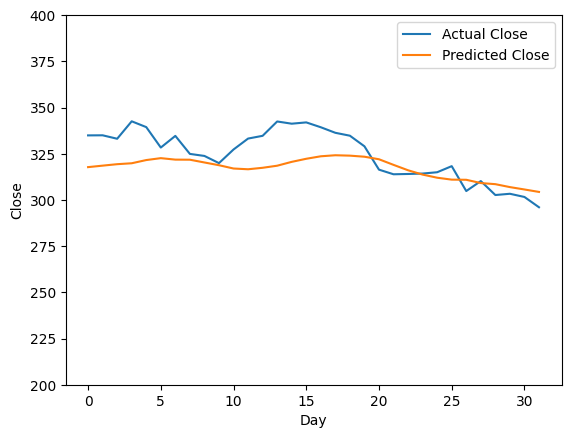

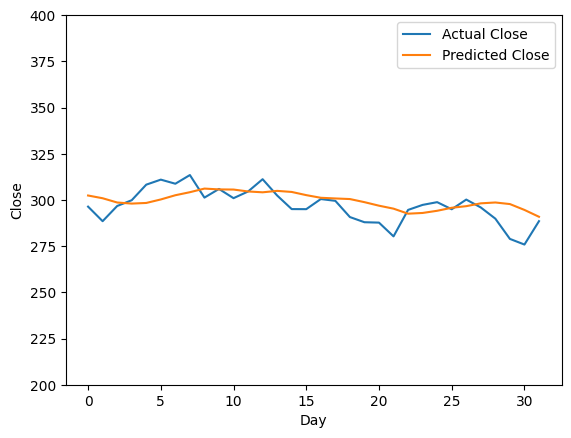

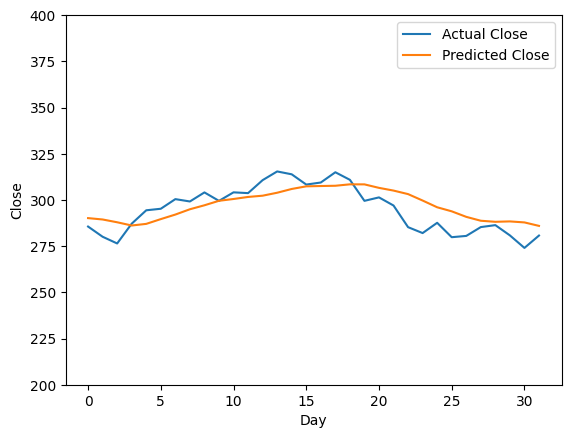

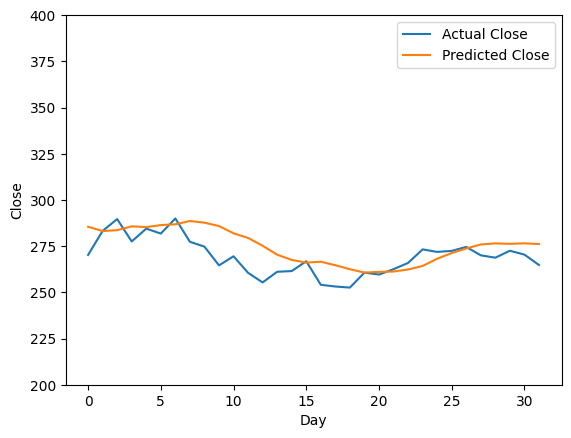

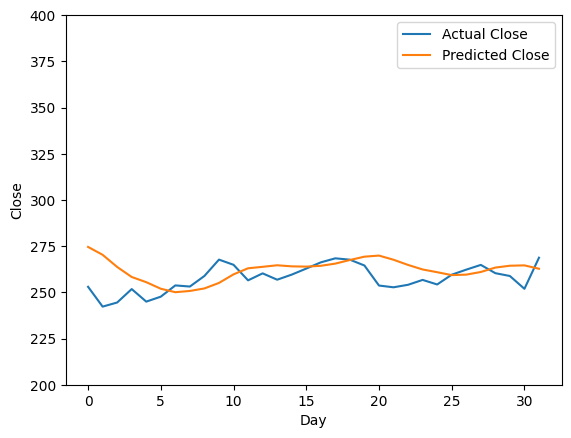

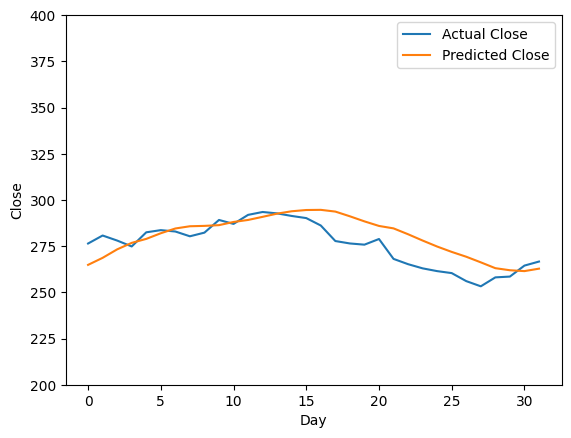

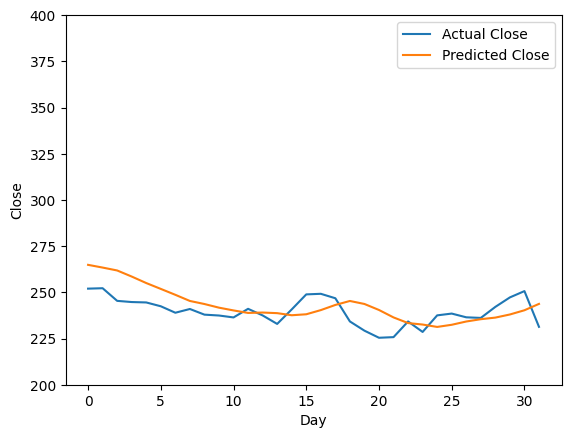

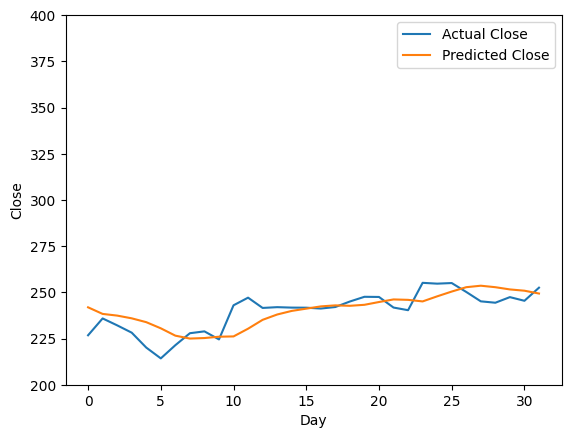

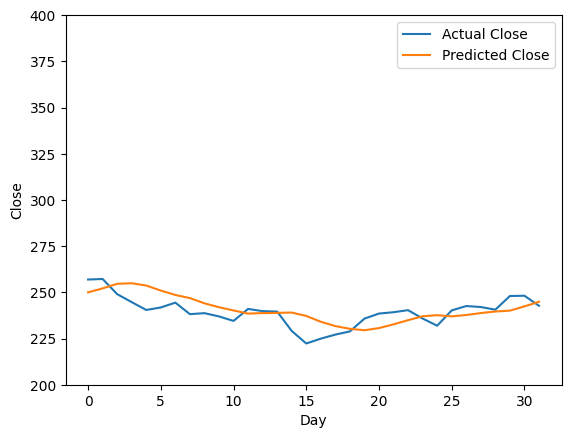

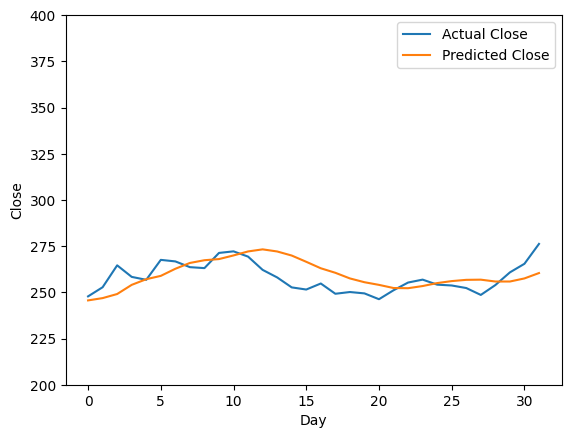

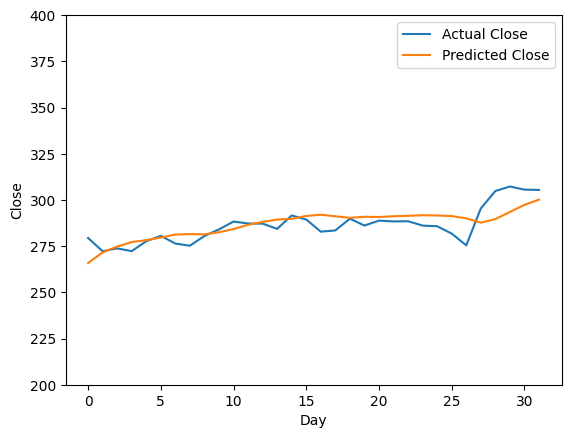

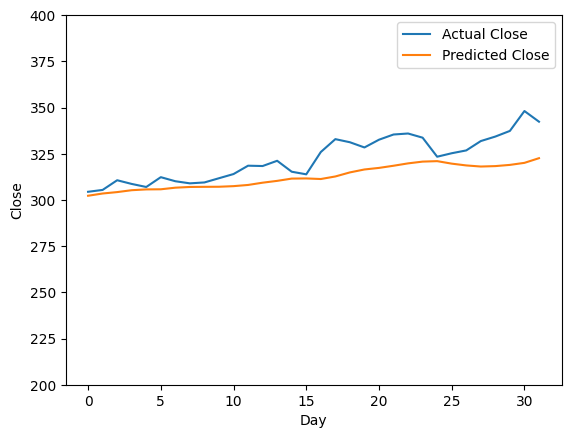

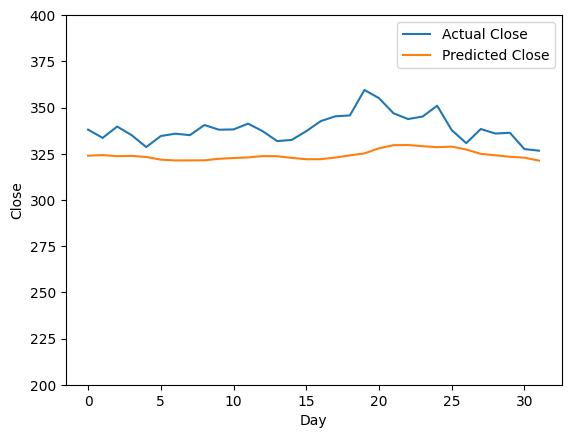

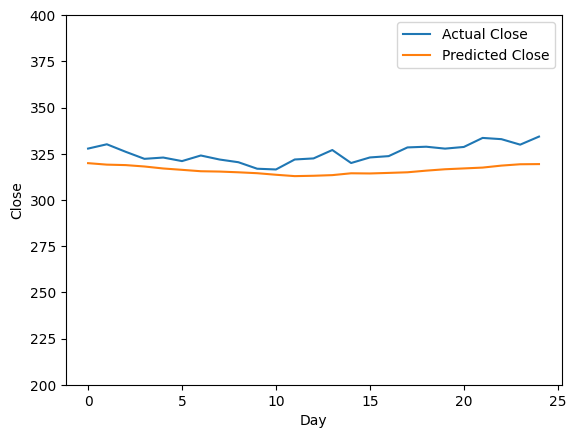

Mean Squared Error (MSE): 0.0031643306928042943


In [261]:
test(test_loader)